# Tf-idf for key textual patterns linked to specific ratings

We use Term Frequency–Inverse Document Frequency (TF-IDF) to identify meaningful patterns in text for predicting M&E ratings. TF-IDF assigns greater weight to words that appear frequently within a specific document but are less common across the entire corpus, helping highlight distinctive terms. We also define the topic length (n-grams) to capture relevant phrases for classification. A Random Forest model is then used to map these text-based patterns to the corresponding M&E ratings.


In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix
from sklearn.preprocessing import label_binarize
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

####  Load dataset

In [3]:
# load df, drop unusable ratings
dt_path = "../01_data/txt_reports.csv"
df = pd.read_csv(dt_path)
df = df[
    df["quality_rating"].isin(["Substantial", "Modest", "High", "Negligible"])
].copy()

#### Functions

In [ ]:
def clean_text(text):
    """
    fn to clean text
    """
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r"[^\w\s-]", " ", text)
        text = re.sub(r"\s+", " ", text).strip()
        text = re.sub(r'[!"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~¡¿\d]', "", text)
        return text
    return ""


def prepare_data_and_train(df, text_column, n_gram_r, test_size=0.3):
    """
    fn for  TF-IDF features and train RF
    """
    le = LabelEncoder()
    df["rating_encoded"] = le.fit_transform(df["quality_rating"])
    texts = df[text_column].fillna("").apply(clean_text)
    y = df["rating_encoded"]

    X_train_texts, X_test_texts, y_train, y_test = train_test_split(
        texts, y, test_size=test_size, random_state=42, stratify=y
    )

    tfidf = TfidfVectorizer(
        ngram_range=n_gram_r, max_features=5000, stop_words="english"
    )
    X_train = tfidf.fit_transform(X_train_texts)
    X_test = tfidf.transform(X_test_texts)

    clf = RandomForestClassifier(
        n_estimators=100, class_weight="balanced", random_state=42, n_jobs=-1
    )
    clf.fit(X_train, y_train)

    return clf, tfidf, X_train, X_test, y_train, y_test, le


def extract_feature_importance(
    clf, tfidf, X_train, y_train, le, section_name, top_n=15
):
    """
    FN for top features for each class
    """
    feature_names = np.array(tfidf.get_feature_names_out())
    class_labels = le.classes_

    records = []

    for class_idx, class_name in enumerate(class_labels):
        y_train_binary = (y_train == class_idx).astype(int)
        clf_binary = RandomForestClassifier(
            n_estimators=50, class_weight="balanced", random_state=42
        )
        clf_binary.fit(X_train, y_train_binary)

        importances = clf_binary.feature_importances_
        sorted_idx = np.argsort(importances)[::-1][:top_n]

        for rank, i in enumerate(sorted_idx):
            records.append(
                {
                    "section": section_name,
                    "class": class_name,
                    "ngram": feature_names[i],
                    "importance": importances[i],
                    "rank": rank + 1,
                }
            )

    return pd.DataFrame.from_records(records)


def evaluate_model(clf, X_test, y_test, le, section_name):
    """
    fn to evaluate model
    """

    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)

    f1 = f1_score(y_test, y_pred, average="weighted")

    n_classes = len(le.classes_)

    evaluation_metrics = {
        "section": section_name,
        "f1_score": f1,
        "accuracy": (y_pred == y_test).mean(),
        "class_f1_scores": f1_score(
            y_test, y_pred, average=None, labels=range(n_classes)
        ),
        "class_names": le.classes_,
        "confusion_matrix": pd.crosstab(
            pd.Series(y_test, name="Actual"),
            pd.Series(y_pred, name="Predicted"),
            rownames=["Actual"],
            colnames=["Predicted"],
        ),
    }

    return evaluation_metrics


def plot_roc_and_confusion_matrix(clf, X_test, y_test, le, section_name):
    y_pred_proba = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    n_classes = len(le.classes_)
    y_test_bin = label_binarize(y_test, classes=range(n_classes))

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    colors = ["blue", "red", "green", "purple"]
    for i, color, class_name in zip(range(n_classes), colors, le.classes_):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        axes[0].plot(
            fpr, tpr, color=color, lw=2, label=f"{class_name} (AUC = {roc_auc:.2f})"
        )

    axes[0].plot([0, 1], [0, 1], "k--", lw=2)
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    axes[0].set_title(f"ROC Curve for {section_name}")
    axes[0].legend(loc="lower right")

    cm = confusion_matrix(y_test, y_pred)

    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(
        cm_norm,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=le.classes_,
        yticklabels=le.classes_,
        ax=axes[1],
    )
    axes[1].set_ylabel("Actual")
    axes[1].set_xlabel("Predicted")
    axes[1].set_title(f"Normalized Confusion Matrix for {section_name}")

    plt.tight_layout()
    plt.show()

## Two word pattern identification linking Design Section to M&E Rating


Top features for each class:

High:
  - evaluative activities included (importance: 0.0105)
  - verification agency (importance: 0.0088)
  - track progress (importance: 0.0086)
  - completion report icr (importance: 0.0086)
  - independent evaluation (importance: 0.0085)

Modest:
  - clearly specified (importance: 0.0082)
  - theory change (importance: 0.0067)
  - clearly stated (importance: 0.0064)
  - management information (importance: 0.0063)
  - outcome indicators (importance: 0.0044)

Negligible:
  - monitoring evaluation (importance: 0.0232)
  - design framework (importance: 0.0123)
  - collecting data (importance: 0.0102)
  - monitoring evaluation design (importance: 0.0099)
  - outcome targets (importance: 0.0096)

Substantial:
  - theory change (importance: 0.0088)
  - clearly specified (importance: 0.0066)
  - management information (importance: 0.0065)
  - data collection (importance: 0.0048)
  - defined measurable (importance: 0.0047)


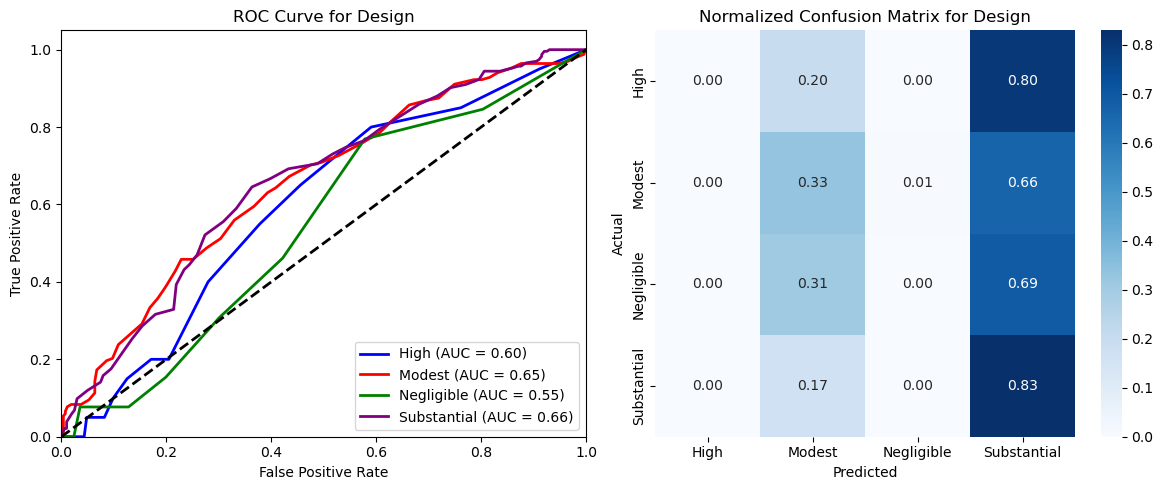

In [ ]:
clf, tfidf, X_train, X_test, y_train, y_test, le = prepare_data_and_train(
    df, "design_text", (2, 3)
)
section_name = "Design"

feature_importance_df = extract_feature_importance(
    clf, tfidf, X_train, y_train, le, section_name
)

evaluation_results = evaluate_model(clf, X_test, y_test, le, section_name)


print("\nTop features for each class:")
for class_name in le.classes_:
    print(f"\n{class_name}:")
    class_features = feature_importance_df[feature_importance_df["class"] == class_name]
    for _, row in class_features.head(5).iterrows():
        print(f"  - {row['ngram']} (importance: {row['importance']:.4f})")


plot_roc_and_confusion_matrix(clf, X_test, y_test, le, section_name)

### Results, limitations and biases

The ROC curve shows low predicted performance for most of the classes and the confusion matrix shows how the model fails to predict Negligible and High ratings. The latter can be explained by the imbalanced data, where the class distribution is as follows:
- Substantial:778
- Modest:560
- High: 67
- Negligible:43

Hence, the model is biased towards the dominating classes. 

Regarding the results of the most important patterns (bigrams), there is an overlap of patterns for the Substantial and Modest ratings:   
- clearly specified 
- theory change 
- management information

which could explain the low precision of the model. 


## Two word pattern identification linking Implementation Section to M&E Rating


Top features for each class:

High:
  - implemented designed (importance: 0.0145)
  - tracked planned (importance: 0.0130)
  - impact evaluation (importance: 0.0130)
  - project implementation (importance: 0.0090)
  - project supported (importance: 0.0088)

Modest:
  - project implementation (importance: 0.0094)
  - real time (importance: 0.0076)
  - outcome indicators (importance: 0.0071)
  - results indicators (importance: 0.0060)
  - according icr (importance: 0.0054)

Negligible:
  - did happen (importance: 0.0240)
  - measure progress (importance: 0.0162)
  - evaluation group ieg (importance: 0.0148)
  - framework updated (importance: 0.0132)
  - icr project (importance: 0.0118)

Substantial:
  - project implementation (importance: 0.0062)
  - according icr (importance: 0.0059)
  - good quality (importance: 0.0057)
  - intermediate results (importance: 0.0048)
  - icr paragraph (importance: 0.0045)


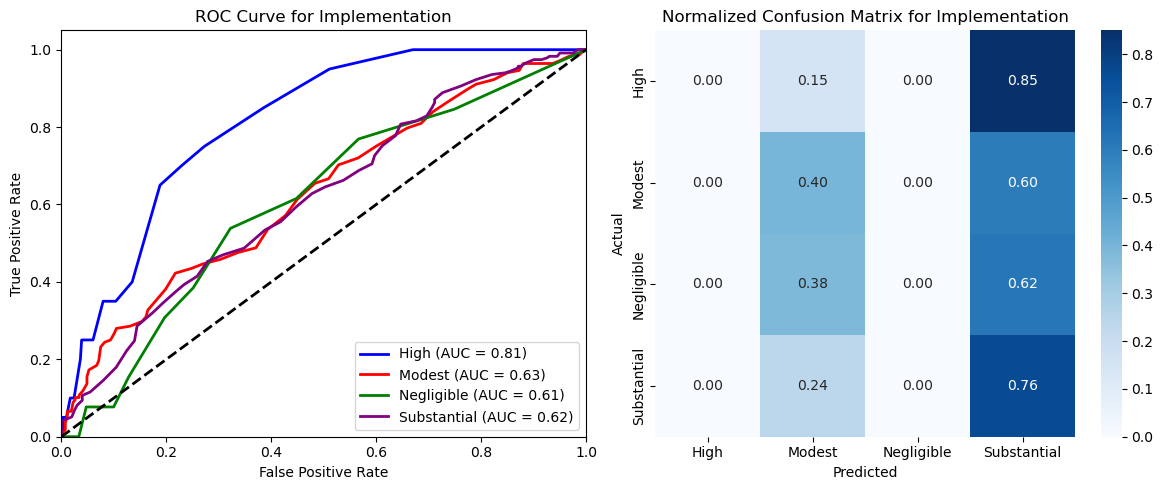

In [ ]:
clf, tfidf, X_train, X_test, y_train, y_test, le = prepare_data_and_train(
    df, "implementation_text", (2, 3)
)
section_name = "Implementation"

feature_importance_df = extract_feature_importance(
    clf, tfidf, X_train, y_train, le, section_name
)

evaluation_results = evaluate_model(clf, X_test, y_test, le, section_name)


print("\nTop features for each class:")
for class_name in le.classes_:
    print(f"\n{class_name}:")
    class_features = feature_importance_df[feature_importance_df["class"] == class_name]
    for _, row in class_features.head(5).iterrows():
        print(f"  - {row['ngram']} (importance: {row['importance']:.4f})")


plot_roc_and_confusion_matrix(clf, X_test, y_test, le, section_name)

### Results, limitations and biases

The ROC curve shows better performance than de Design model, but the confusion matrix shows again how the model fails to predict Negligible and High ratings. The latter can be explained by the imbalanced data, where the class distribution is as follows:
- Substantial:778
- Modest:560
- High: 67
- Negligible:43
Hence, the model is biased towards the dominating classes. 

Regarding the results of the most important patterns (bigrams), there is an overlap of patterns for the Substantial and Modest ratings for one feature, Project Implementation, which could explain the low precision of the model for these classes. The pattern coincided with the name of the section, so in future analysis could be eliminated for better results. 

## Two word pattern identification linking Utilization Section to M&E Rating


Top features for each class:

High:
  - rated high (importance: 0.0123)
  - project monitoring (importance: 0.0103)
  - results based (importance: 0.0098)
  - quality rated high (importance: 0.0087)
  - course correction (importance: 0.0082)

Modest:
  - rated modest (importance: 0.0536)
  - rated substantial (importance: 0.0284)
  - quality rated modest (importance: 0.0263)
  - quality rated substantial (importance: 0.0227)
  - quality rated (importance: 0.0096)

Negligible:
  - utilized project (importance: 0.0270)
  - project monitoring (importance: 0.0193)
  - notes data (importance: 0.0125)
  - inform decision making (importance: 0.0120)
  - used inform decision (importance: 0.0113)

Substantial:
  - rated substantial (importance: 0.0371)
  - rated modest (importance: 0.0349)
  - quality rated substantial (importance: 0.0275)
  - quality rated modest (importance: 0.0149)
  - quality rated (importance: 0.0109)


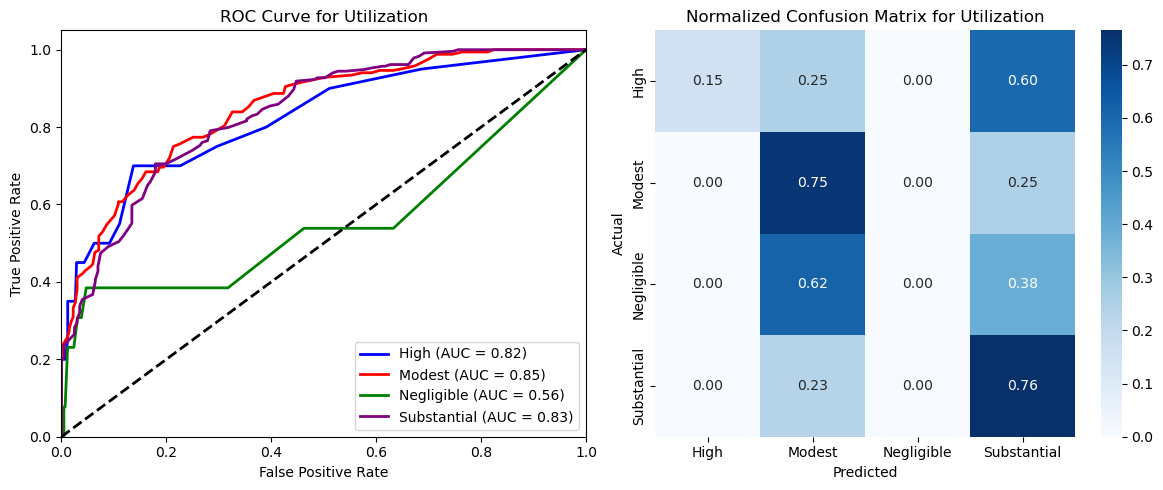

In [ ]:
clf, tfidf, X_train, X_test, y_train, y_test, le = prepare_data_and_train(
    df, "utilization_text", (2, 3)
)
section_name = "Utilization"

feature_importance_df = extract_feature_importance(
    clf, tfidf, X_train, y_train, le, section_name
)

evaluation_results = evaluate_model(clf, X_test, y_test, le, section_name)


print("\nTop features for each class:")
for class_name in le.classes_:
    print(f"\n{class_name}:")
    class_features = feature_importance_df[feature_importance_df["class"] == class_name]
    for _, row in class_features.head(5).iterrows():
        print(f"  - {row['ngram']} (importance: {row['importance']:.4f})")


plot_roc_and_confusion_matrix(clf, X_test, y_test, le, section_name)

### Results, limitations and biases


The ROC curve shows how the Utilization Section has the best performance of all models.  The confusion matrix shows again how the model fails to predict Negligible and High ratings due to the unbalanced dataset. 

Regarding the results of the most important patterns (bigrams), the patters (bigrams) for Modest and Substantial classes, show a tendency to overstate the name of the class, example: 
Modest: - quality rated modest, - quality modest. 